# Diabetic Retinopathy Classification: Data Preprocessing

### Part 1: Dataset Loading and Initial Exploration

This notebook outlines the initial data handling pipeline for the APTOS 2019 dataset. The process begins with setting up the environment, downloading the dataset, and performing an initial exploratory analysis to understand its structure and content.

In [2]:
# Install required libraries for the project
!pip install -q kaggle
!pip install -q kagglehub
!pip install -q albumentations

# Import core libraries
import os
import shutil
import time
import pandas as pd
import numpy as np
import cv2 # OpenCV for image processing
import matplotlib.pyplot as plt
from google.colab import drive
import tensorflow as tf
import kagglehub

print("Libraries imported successfully.")

Libraries imported successfully.


### 2.1. Download and Relocate the Dataset

The dataset is first downloaded from Kaggle Hub. To maintain a structured workspace, the data is then copied from the local cache to a dedicated project directory `/content/aptos_dataset`.

In [3]:
# Download the dataset using the Kaggle Hub API
path = kagglehub.dataset_download("mariaherrerot/aptos2019")
print("Kaggle Hub download path:", path)
KAGGLEHUB_PATH = path

# Mount Google Drive for later stages
drive.mount('/content/drive')

# Define source and destination paths for relocation
SOURCE_DATA_PATH = KAGGLEHUB_PATH
DESTINATION_BASE_PATH = '/content/aptos_dataset'

# Execute the copy operation
print(f"\nCopying dataset from {SOURCE_DATA_PATH} to {DESTINATION_BASE_PATH}...")
start_copy_time = time.time()

try:
    # Avoid re-copying if the directory already exists
    if os.path.exists(DESTINATION_BASE_PATH):
        print(f"Destination path already exists. Skipping copy.")
    else:
        shutil.copytree(SOURCE_DATA_PATH, DESTINATION_BASE_PATH)
        print("Dataset copied successfully.")

    end_copy_time = time.time()
    copy_duration = end_copy_time - start_copy_time
    print(f"\nOperation complete. Data is now located at {DESTINATION_BASE_PATH}.")
    print(f"Duration: {copy_duration:.2f} seconds.")

    # List the contents to verify the copy
    print("\nContents of destination directory:")
    !ls -lh {DESTINATION_BASE_PATH}

except Exception as e:
    print(f"\nAn error occurred during the copy operation: {e}")

Kaggle Hub download path: /kaggle/input/aptos2019
Mounted at /content/drive

Copying dataset from /kaggle/input/aptos2019 to /content/aptos_dataset...
Dataset copied successfully.

Operation complete. Data is now located at /content/aptos_dataset.
Duration: 213.91 seconds.

Contents of destination directory:
total 72K
-rw-r--r-- 1 root root 6.8K Aug  4 08:35 test.csv
drwxr-sr-x 3 root root 4.0K Aug  4 08:35 test_images
-rw-r--r-- 1 root root  43K Aug  4 08:35 train_1.csv
drwxr-sr-x 3 root root 4.0K Aug  4 08:35 train_images
-rw-r--r-- 1 root root 5.8K Aug  4 08:36 valid.csv
drwxr-sr-x 3 root root 4.0K Aug  4 08:36 val_images


### 2.2. Define Project Constants and Paths

With the data in its final location, project-wide constants such as image dimensions and paths to the CSV files and image directories are defined.

In [4]:
# Define constants for the data pipeline
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
NUM_CLASSES = 5 # Corresponds to the 5 DR severity levels

# Define paths based on the new destination directory
TRAIN_CSV_PATH = os.path.join(DESTINATION_BASE_PATH, 'train_1.csv')
VALID_CSV_PATH = os.path.join(DESTINATION_BASE_PATH, 'valid.csv')
TEST_CSV_PATH = os.path.join(DESTINATION_BASE_PATH, 'test.csv')

TRAIN_IMG_DIR = os.path.join(DESTINATION_BASE_PATH, 'train_images', 'train_images')
VALID_IMG_DIR = os.path.join(DESTINATION_BASE_PATH, 'val_images', 'val_images')
TEST_IMG_DIR = os.path.join(DESTINATION_BASE_PATH, 'test_images', 'test_images')

print(f"Input Image Size: {IMG_SIZE}")
print(f"Train CSV Path: {TRAIN_CSV_PATH}")
print(f"Train Image Directory: {TRAIN_IMG_DIR}")

Input Image Size: (224, 224)
Train CSV Path: /content/aptos_dataset/train_1.csv
Train Image Directory: /content/aptos_dataset/train_images/train_images


### 2.3. Load and Inspect CSV Metadata

The CSV files are loaded into pandas DataFrames. A preliminary inspection is performed to review the data structure, check for missing values, and analyze the class distribution.

In [5]:
try:
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    valid_df = pd.read_csv(VALID_CSV_PATH)
    test_df = pd.read_csv(TEST_CSV_PATH)

    print("--- Train DataFrame ---")
    print(f"Shape: {train_df.shape}")
    print(train_df.head())
    print("\nClass Distribution (Training):")
    print(train_df['diagnosis'].value_counts().sort_index())

    print("\n--- Validation DataFrame ---")
    print(f"Shape: {valid_df.shape}")
    print(valid_df.head())
    print("\nClass Distribution (Validation):")
    print(valid_df['diagnosis'].value_counts().sort_index())

except FileNotFoundError as e:
    print(f"Error: A CSV file was not found. Please verify paths. Details: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

--- Train DataFrame ---
Shape: (2930, 2)
        id_code  diagnosis
0  1ae8c165fd53          2
1  1b329a127307          1
2  1b32e1d775ea          4
3  1b3647865779          0
4  1b398c0494d1          0

Class Distribution (Training):
diagnosis
0    1434
1     300
2     808
3     154
4     234
Name: count, dtype: int64

--- Validation DataFrame ---
Shape: (366, 2)
        id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

Class Distribution (Validation):
diagnosis
0    172
1     40
2    104
3     22
4     28
Name: count, dtype: int64


### 2.4. Visualize Original Image Samples

To confirm that the images are correctly associated with their labels, a random subset of images from the training set is displayed.

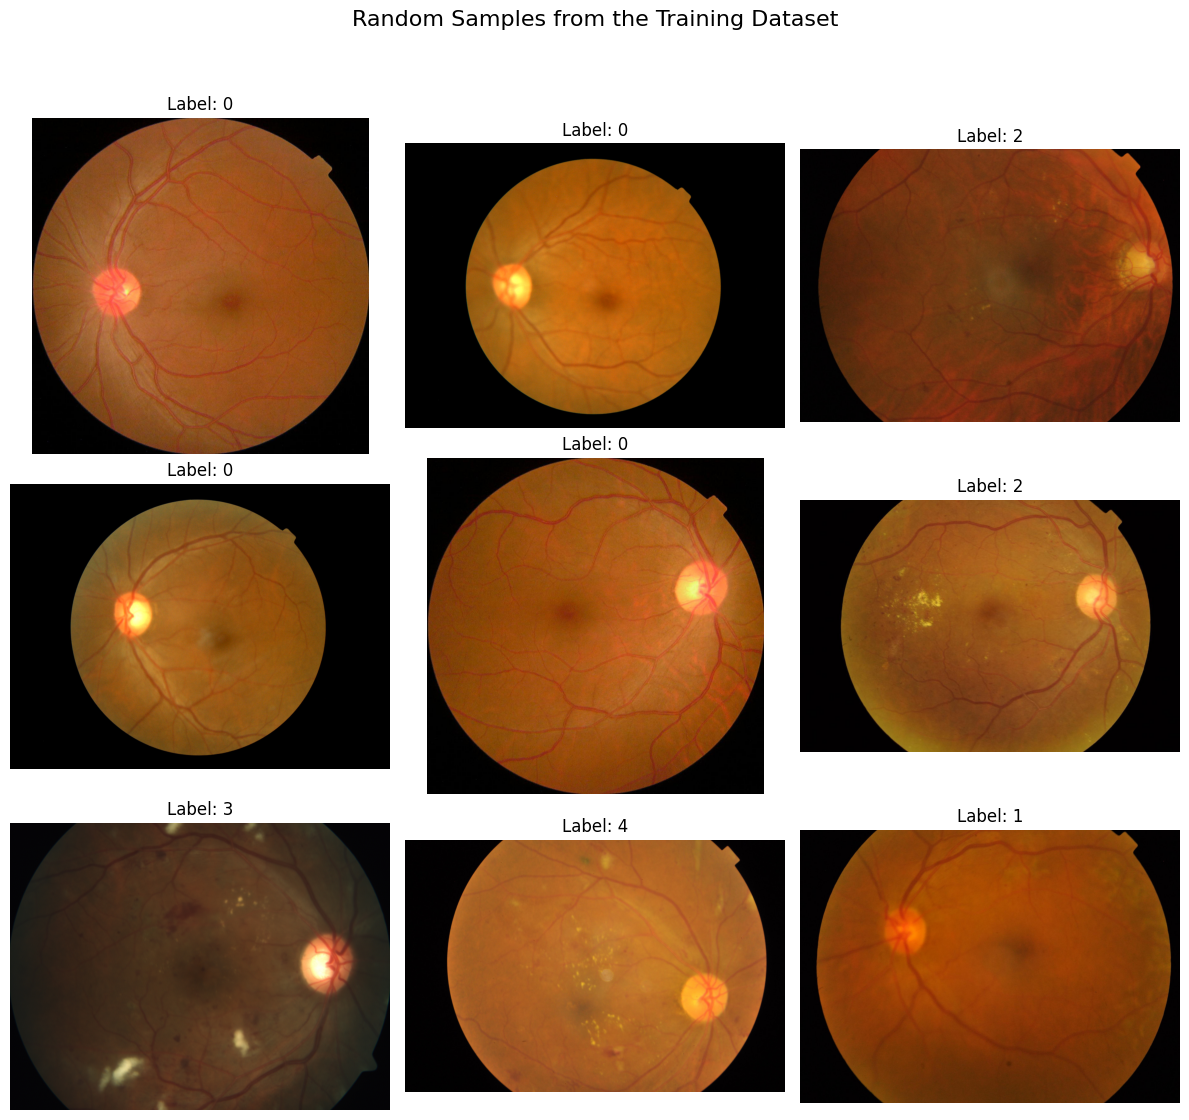

In [6]:
def plot_random_original_samples(df, img_dir, num_samples=9):
    """
    Plots a grid of random original images from the provided dataframe.
    """
    sample_df = df.sample(n=num_samples)
    plt.figure(figsize=(12, 12))
    plt.suptitle("Random Samples from the Training Dataset", fontsize=16)

    for i, (index, row) in enumerate(sample_df.iterrows()):
        ax = plt.subplot(3, 3, i + 1)
        img_path = os.path.join(img_dir, f"{row['id_code']}.png")
        try:
            # Read image and convert from BGR to RGB for correct color display
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.imshow(img_rgb)
            plt.title(f"Label: {row['diagnosis']}")
            plt.axis("off")
        except Exception as e:
             plt.title(f"ID: {row['id_code']}\nError Loading")
             plt.axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Visualize samples from the training data
plot_random_original_samples(train_df, TRAIN_IMG_DIR)